In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import math
import json
import shutil
import datetime

In [3]:
f = "../../outputs/llm"
llm_dirs = os.listdir(f)
if ".DS_Store" in llm_dirs:  llm_dirs.remove(".DS_Store")
f = "../../outputs/control"
control_dirs = os.listdir(f)
if ".DS_Store" in control_dirs: control_dirs.remove(".DS_Store")


In [57]:
overlap = set(control_dirs) & set(llm_dirs)

In [67]:
#classify dirs that overlap between llm and control, mostly overlap because initially used terms data-science when quering llm

control = []
llm = []
for repo in list(overlap):
    repoData = ParseRepo(repo)
    topics = repoData.getGithubTopics()
#     keywords = ["llm","nlp","jax","stable diffusion", "unsupervised learning", "mxnet", "jax","artificial intelligence"]
    keywords_values = repoData.parseReadMe().values()
    if "data" and "science" in repoData.name.lower():
        control.append(repo)
    # contains any keyword then llm
    elif sum(keywords_values) >0:
        llm.append(repo)
    else: # then data science
        control.append(repo)


for repo in control:
    shutil.rmtree("../outputs/llm/"+repo)
    
for repo in llm:
    shutil.rmtree("../outputs/control/"+repo)

In [4]:
# Class to Read forks and data from specific repo
class ParseRepo():
    def __init__(self,repo, outputDir="llm"):
        self.outputDir = "../../outputs/"+outputDir
        self.name = "/".join(repo.split("*"))
        self.path = os.path.join(self.outputDir, repo)
        self.info = self.readGithubInfo()
        self.forks = self.getForksData()
        
    def getReadMe(self):
        with open(f"{self.path}/README.md", "r") as file:
            readme = file.read().lower()
        return readme
    
    def parseReadMe(self):
        self.keywords = ["llm","nlp","jax","stable diffusion", "unsupervised learning", "mxnet", "jax","artificial intelligence"]
        readme = self.getReadMe()
        keyword_counts = {keyword:readme.count(keyword) for keyword in self.keywords}
        return keyword_counts
    
    def readGithubInfo(self):
        with open(f"{self.path}/info.json", 'r') as f:
            data = json.load(f)
        return data
    
    def getGithubTopics(self):
        info = self.readGithubInfo()
        return info["data"]["topics"]
    
    def getForksData(self):
        df = pd.read_csv(self.path+"/forks.csv", low_memory=False)
        df = df.sort_values("created_at")
        df['created_at'] = pd.to_datetime(df['created_at'])
        return df
    

        
    

100
200
300
400
500
600
finished LLM
100
200
300
400
500
finished Control


/opt/homebrew/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


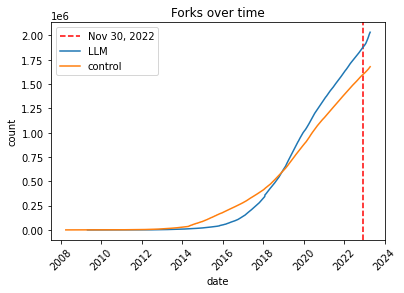

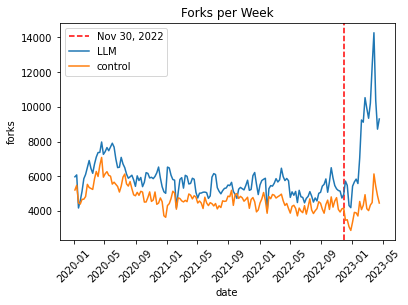

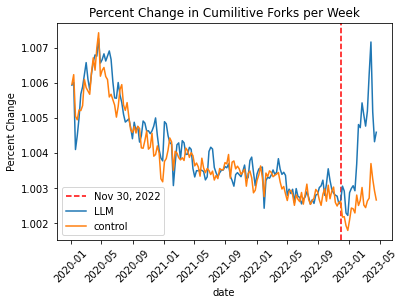

date  forks    count  Percent Change
520 2020-01-06   5972  1011560        1.005939
521 2020-01-13   6081  1017641        1.006012
522 2020-01-20   4175  1021816        1.004103
523 2020-01-27   4596  1026412        1.004498
524 2020-02-03   5134  1031546        1.005002
..         ...    ...      ...             ...
687 2023-03-20  12356  1990925        1.006245
688 2023-03-27  14274  2005199        1.007170
689 2023-04-03  10374  2015573        1.005174
690 2023-04-10   8718  2024291        1.004325
691 2023-04-17   9303  2033594        1.004596

[172 rows x 4 columns]

In [6]:
class Analysis:
    #Takes dataframe with different dates that forks were created at and groups them by week, then finds cumilitive sums as weeks progress
    def getCumData(self, df):
        df.loc[:, "created_at"] = df["created_at"].dt.to_period('W')
        df = df.reset_index()
        data = df.groupby("created_at")["index"].count().reset_index()
        data = data.rename(columns={"created_at":"date", "index":"forks"})
#         data["date"] = data["date"].dt.to_timestamp()
        data["date"] = data["date"].apply(lambda x: x.start_time)
        data["count"] = data["forks"].cumsum()
        data = data.drop(data.index[-1]) #the final week has incomplete data and will show less forks
        return data
    
    #finds the percent changes in cumilitive sum of forks between weeks and returns
    def getPercentChange(self, df):
        forks = list(df["count"])
        percent_change = [forks[i]/forks[i-1] for i,x in list(enumerate(forks))[1:]]
        percent_change = [np.nan] + percent_change
        df["Percent Change"] = percent_change
        return df.loc[:,["date","Percent Change"]]
    
    def graphForksOverTime(self, llmForks, controlForks, y, title):
        plt.axvline(x=datetime.date(2022, 11, 30), color='red', linestyle='--', label='Nov 30, 2022')
        sns.lineplot(data=llmForks, x="date", y=y, label="LLM")
        sns.lineplot(data=controlForks, x="date", y=y, label="control")
        plt.xticks(rotation=45)
        plt.title(title)
        plt.savefig("graphs/"+title+".png", dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.show()
    
    # takes to long to read all forks every time so this reads all forks and puts into csv file, so it can be read faster
    def compileData(self):
        self.LLMForks = pd.DataFrame()
        count = 0
        for repo in llm_dirs:
            count += 1
            if count % 100==0: print(count)
            repoData = ParseRepo(repo, "llm")
            repoforks = repoData.forks[["created_at"]]
            self.LLMForks = pd.concat([self.LLMForks, repoforks], axis=0, ignore_index=True)
       
        self.LLMForks[["created_at"]].to_csv("llm.csv")
        print("finished LLM")
        
        self.ControlForks = pd.DataFrame()
        count = 0
        for repo in control_dirs:
            count += 1
            if count % 100==0: print(count)
            repoData = ParseRepo(repo, "control")
            repoforks = repoData.forks[["created_at"]]
            self.ControlForks = pd.concat([self.ControlForks, repoforks], axis=0, ignore_index=True)
        
        self.ControlForks[["created_at"]].to_csv("control.csv")
        print("finished Control")
        
    def getForksAfterDate(self,df):
        cutoff_date = pd.Timestamp("2020-01-01")
        stop_date = pd.Timestamp("2024-01-01")
        forks_after_date = df[(df["date"] >= cutoff_date) & (df["date"] < stop_date)]
        return forks_after_date
    
    def compare(self):
        self.LLMForks = pd.read_csv("llm.csv",index_col=0)
        self.ControlForks = pd.read_csv("control.csv",index_col=0)
        self.LLMForks["created_at"] = pd.to_datetime(self.LLMForks["created_at"])
        self.ControlForks["created_at"] = pd.to_datetime(self.ControlForks["created_at"])
        
        self.LLMForksCum = self.getCumData(self.LLMForks)
        self.ControlForksCum = self.getCumData(self.ControlForks)
        self.getPercentChange(self.LLMForksCum)
        self.getPercentChange(self.ControlForksCum)
        
        self.graphForksOverTime(self.LLMForksCum,self.ControlForksCum, "count", "Forks over time")
        self.LLMForksCum = self.getForksAfterDate(self.LLMForksCum)
        self.ControlForksCum = self.getForksAfterDate(self.ControlForksCum)
        
        self.graphForksOverTime(self.LLMForksCum,self.ControlForksCum, "forks", "Forks per Week")
        
        self.graphForksOverTime(self.LLMForksCum,self.ControlForksCum, "Percent Change", "Percent Change in Cumilitive Forks per Week")
        



        
analysis = Analysis()
analysis.compileData()   
analysis.compare()
analysis.LLMForksCum